In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [56]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.01  # in s
signal_power = 1.0  # in dB
noise_power = 17.5  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 1.00 dB
Noise power:  17.51 dB
SNR:          -16.51 dB
Num samples:  10000


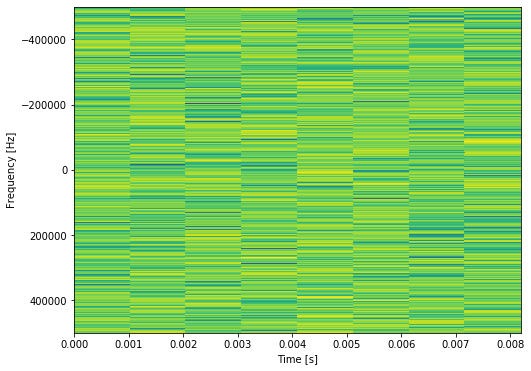

In [3]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=both,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

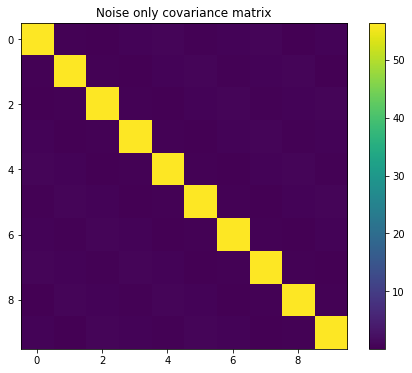

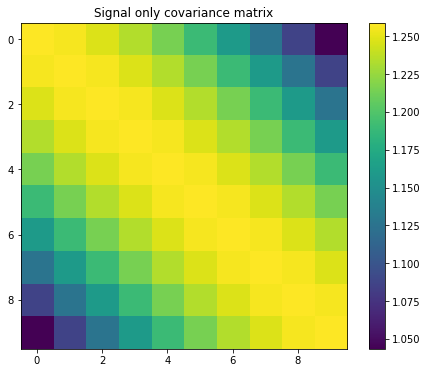

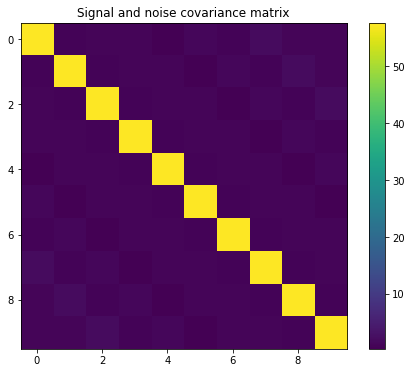

In [57]:
# covariance matrices
cov_size = 10

plt.figure(figsize=(8, 6))
mat_noise = ss.eigen_detector.corr(x=noise, l=cov_size)
plt.imshow(np.abs(mat_noise))
plt.colorbar()
plt.title('Noise only covariance matrix')
plt.show()

plt.figure(figsize=(8, 6))
mat_sig = ss.eigen_detector.corr(x=sig, l=cov_size)
plt.imshow(np.abs(mat_sig))
plt.colorbar()
plt.title('Signal only covariance matrix')
plt.show()

plt.figure(figsize=(8, 6))
mat_both = ss.eigen_detector.corr(x=both, l=cov_size)
plt.imshow(np.abs(mat_both))
plt.colorbar()
plt.title('Signal and noise covariance matrix')
plt.show()

In [5]:
# # plot eigenvalue distribution

# # calculate eigenvalues
# noise_eig_vals = np.abs(linalg.eigvals(mat_noise))
# both_eig_vals = np.abs(linalg.eigvals(mat_both))

# # and plot them together in one graph
# plt.figure(figsize=(8, 6))
# plt.plot(noise_eig_vals, 'ro', alpha=0.7, aa=True, label='Noise only')
# plt.plot(both_eig_vals, 'go', alpha=0.7, aa=True, label='Signal and noise')
# plt.xlabel(r'Eigenvalue number')
# plt.ylabel(r'Magnitude')
# plt.grid(linewidth=0.5)
# plt.title('Covariance matrix eigenvalues')
# plt.legend(loc=0)
# plt.show()

In [61]:
import numpy as np
from scipy import stats
from scipy import linalg
import TracyWidom

from specsens import util

def mme_pd(Ns, L, thr, noise_power, sig_eigv_min, sig_eigv_max, M=1, dB=True):
    if dB:
        noise_power = util.dB_to_factor_power(noise_power)
    tw = TracyWidom.TracyWidom(beta=1)
    mu = ((Ns - 1)**.5 + (M * L)**.5)**2
    v = ((Ns - 1)**.5 + (M * L)**.5) * (1 / ((Ns - 1)**.5) + 1 /
                                        ((M * L)**.5))**(1 / 3)
    fac = (thr * Ns +
           (Ns * (thr * sig_eigv_min - sig_eigv_max)) / noise_power - mu) / v
    return 1 - tw.cdf(fac)


print('min:', np.min(np.abs(linalg.eigvals(mat_sig))))
print('max:', np.max(np.abs(linalg.eigvals(mat_sig))))

print(
    'Pd:',
    #     ss.eigen_stats.mme_pd(Ns=10000,
    mme_pd(Ns=10000,
           L=10,
           thr=1.13247650,
           noise_power=17.5,
           sig_eigv_min=np.min(np.abs(linalg.eigvals(mat_sig))),
           sig_eigv_max=np.max(np.abs(linalg.eigvals(mat_sig))),
           M=0.00015,
           dB=True))

min: 1.7349978292699875e-13
max: 12.14230491696668
Pd: 0.9094819997709787
